In [146]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import rcParams

#path = '/kaggle'
#path = '/tmp/working/' # Standard kaggle container data path
path = '/tmp/working/tmp/kaggle-gearbox-analysis/data' # "./"
input_path = path + '/input/gearbox-fault-diagnosis-elaborated-datasets/stdev/'
broken_dataset  = "broken30hz_stdev_100.csv"
healthy_dataset = "healthy30hz_stdev_100.csv"

## Build healthy/broken dataset

In [147]:
healthyDataset = pd.read_csv(input_path + healthy_dataset)
brokenDataset = pd.read_csv(input_path + broken_dataset)

dataset = pd.concat([healthyDataset, brokenDataset], axis=0)
dataset.describe()

,a1,a2,a3,a4,load,failure
count,20203.000000,20203.000000,20203.000000,20203.000000,20203.000000,20203.000000
mean,5.766842,4.266330,3.847555,4.276706,45.644706,0.497401
std,2.219236,1.162870,1.020591,1.228792,28.660383,0.500006
min,1.468928,1.272738,0.990336,1.111679,0.000000,0.000000
25%,4.164285,3.473209,3.118392,3.409206,20.000000,0.000000
50%,5.337988,4.146414,3.779156,4.211713,50.000000,0.000000
75%,7.003621,4.903647,4.521386,5.078614,70.000000,1.000000
max,23.909199,10.984053,8.273939,10.609798,90.000000,1.000000


# Evaluate classification

In [148]:
# Predictor variable (features)
columns = ['a1', 'a2', 'a3', 'a4', 'load']
X = dataset[columns]
# Target variable: Failure (boolean)
#y = dataset.iloc[:,-1]
y = dataset[['failure']]

# Logistic regression

In [149]:
# Split the dataset: 80% train, 20% test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Logistic regression classifier
from sklearn.linear_model import LogisticRegression

# Setup the model
logis = LogisticRegression(max_iter=1000)

## Evaluate the model

In [150]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
# Define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(logis, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.914 (0.004)


## Train and prediction

In [151]:
# Train the model
logis_trained = logis.fit(X_train,y_train)

y_pred = logis.predict(X_test)
print("Prediction for the test data (first 10 rows):", y_pred[:10])
print("Actual gearbox condition  (first 10 rows):   ", np.array(y_test)[:,0][:10])

Prediction for the test data (first 10 rows): [1 0 0 0 1 1 0 1 0 0]
Actual gearbox condition  (first 10 rows):    [1 0 0 1 1 1 0 1 0 0]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Probability vs. predicted class

In [152]:
# Print np arrays with 2 decimal places, without scientifc notation
np.set_printoptions(suppress=True, precision=2)

In [153]:
y_prob = logis.predict_proba(X_test)[:,1]
print("Probability for the test data (first 10 rows): \n", y_prob[:10])

Probability for the test data (first 10 rows): 
 [1.   0.   0.   0.14 1.   0.95 0.   0.99 0.   0.19]


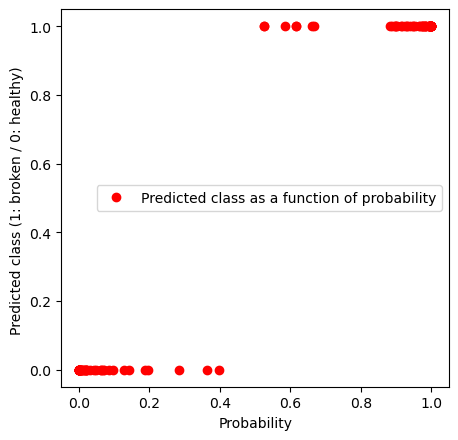

In [154]:
# Select the first 100 points for clarity in the graph
n_points = 100
probability = y_prob[:n_points]
pred_class = np.array(y_pred)[:n_points]

# Plot the graph
plt.figure(figsize = (5,5), dpi=100)
plt.plot(probability, pred_class, 'o', color='red', label = "Predicted class as a function of probability")
#plt.plot(y_pred, y_prob, 'o', color='black');

plt.xlabel('Probability')
plt.ylabel('Predicted class (1: broken / 0: healthy) ')
plt.legend()
plt.show()

### Probability vs. actual class

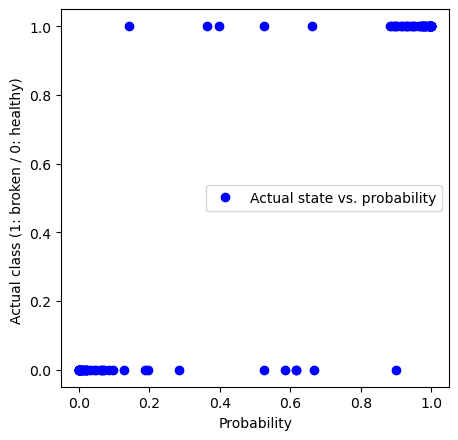

In [155]:
# Select the first 100 points for clarity in the graph
n_points = 100
probability = y_prob[:n_points]
actual_class = np.array(y_test)[:n_points,0]

# Plot the graph
plt.figure(figsize = (5,5), dpi=100)
plt.plot(probability, actual_class, 'o', color='blue', label = "Actual state vs. probability")

plt.xlabel('Probability')
plt.ylabel('Actual class (1: broken / 0: healthy) ')

plt.legend()

plt.show()

### Probability vs. sensor data

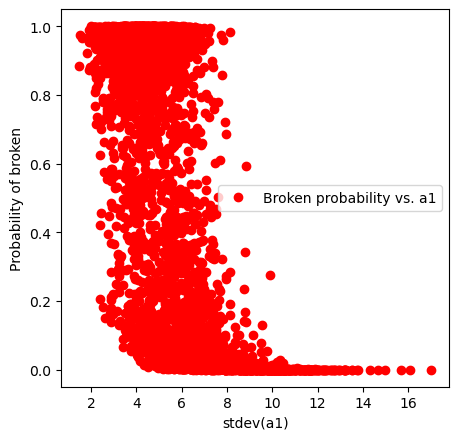

In [156]:
plt.figure(figsize = (5,5), dpi=100)

a1 = X_test.iloc[:,0]
a2 = X_test.iloc[:,1]
a3 = X_test.iloc[:,2]
a4 = X_test.iloc[:,3]

plt.plot(a1, y_prob, 'o', color='red', label = "Broken probability vs. a1")
#plt.plot(y_pred, y_prob, 'o', color='black');

plt.xlabel('stdev(a1)')
plt.ylabel('Probability of broken')

plt.legend()

plt.show()

## Confusion matrix

In [157]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_test)
cm

array([[1851,  194],
       [ 167, 1829]])

In [158]:
# .score returns the mean accuracy on the given test data and labels
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
print( logis.score(X_test,y_test) , logis.score(X_train,y_train) )

0.9106656768126701 0.915542630862517


## Classification report

In [159]:
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2018
           1       0.92      0.90      0.91      2023

    accuracy                           0.91      4041
   macro avg       0.91      0.91      0.91      4041
weighted avg       0.91      0.91      0.91      4041



## ROC curve

In [160]:
# For the ROC curve we need not only the predicted class ('Outcome'), but also the scores on what the predictions are based
# * if threshold 0
#  ** predict>0 => Outcome=1
#  ** predict<0 => Outcome=0 
#  - Remember that predictions were calculated with METHOD .predict(X_test)
#  - Now we also have to include METHOD .decision_function(X_test)
y_pred_score = logis.decision_function(X_test)

In [161]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

# If using the test set (X_test, y_test)
fpr,tpr,threshold= roc_curve(y_test, y_pred_score)

In [162]:
# Area Under Curve
lr_auc = auc(fpr, tpr)
print("AUC=", lr_auc)

AUC= 0.972162303970151


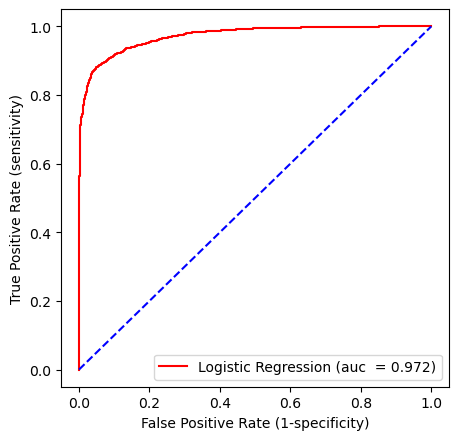

In [163]:
# This default size comes from above
#rcParams['figure.figsize'] = 12, 8

plt.figure(figsize = (5,5), dpi=100)

plt.plot(fpr, tpr, color='red', linestyle='-', label = "Logistic Regression (auc  = %0.3f)"%lr_auc)
plt.plot([0,1],[0,1],color='blue',linestyle='--')

plt.xlabel('False Positive Rate (1-specificity)')
plt.ylabel('True Positive Rate (sensitivity)')

plt.legend()

plt.show()